<a href="https://colab.research.google.com/github/AFBA1993/DeepLearningTutorials/blob/main/RNNLSTM/petr4_recorrente_prev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
base = pd.read_csv('/content/drive/MyDrive/UdemyDeepCSVs/petr4_treinamento.csv')
base = base.dropna()
base_treinamento = base.iloc[:, 1:7].values

In [5]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [3]:
normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,0:1])

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [6]:
previsores = []
preco_real = []
for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0:6])
    preco_real.append(base_treinamento_normalizada[i, 0])
previsores, preco_real = np.array(previsores), np.array(preco_real)

In [7]:
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 6)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'sigmoid'))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

In [8]:
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss', 
                      save_best_only = True, verbose = 1)
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32,
              callbacks = [es, rlr, mcp])

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 0.0172 - mean_absolute_error: 0.0989
Epoch 00001: loss improved from inf to 0.01723, saving model to pesos.h5
36/36 [==============================] - 12s 174ms/step - loss: 0.0172 - mean_absolute_error: 0.0989 - lr: 0.0010
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0596
Epoch 00002: loss improved from 0.01723 to 0.00590, saving model to pesos.h5
36/36 [==============================] - 6s 168ms/step - loss: 0.0059 - mean_absolute_error: 0.0596 - lr: 0.0010
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0497
Epoch 00003: loss improved from 0.00590 to 0.00416, saving model to pesos.h5
36/36 [==============================] - 6s 169ms/step - loss: 0.0042 - mean_absolute_error: 0.0497 - lr: 0.0010
Epoch 4/100
36/36 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0487
Epoch 000

In [9]:
base_teste = pd.read_csv('/content/drive/MyDrive/UdemyDeepCSVs/petr4_teste.csv')
preco_real_teste = base_teste.iloc[:, 1:2].values
frames = [base, base_teste]
base_completa = pd.concat(frames)
base_completa = base_completa.drop('Date', axis = 1)

In [10]:
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = normalizador.transform(entradas)

X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0:6])
X_teste = np.array(X_teste)


In [11]:
previsoes = regressor.predict(X_teste)
previsoes = normalizador_previsao.inverse_transform(previsoes)

In [12]:
previsoes.mean()
preco_real_teste.mean()

17.87454563636364

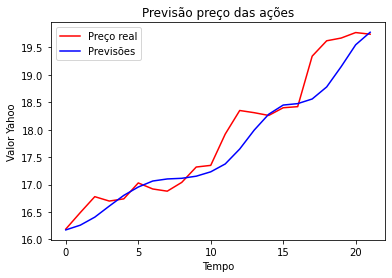

In [13]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()
